# PARAMETER ESTIMATION

# Questions

In this homework, you will do a parameter estimation for
BioModels model 45.


1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.
   1. (10 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (60 pts) **Experiment Implementation**. Implement a doFit function

   
1. (20 pts) **Experiment Execution and Analysis**. Do a 3, 5, and 10 fold cross validation using alternating folds for the 3 datasets. That is, fold 1 has the points 1, 11, 21, ..;
fold 2 has the points 2, 12, 22, ...; and so on. 
   1. (5 pts) Construct heatmaps for the standard deviation of model $R^2$ and the standard deviation of ``beta`` where the horizontal axis is standard deviation of noise in observed data and the vertical axis
   is the number of folds.
   1. (5 pts) For $R^2$, how is variability affected
by the number of folds? How is variability affected by the variability of the training data?
   1. (5 pts) For ``beta``, how is variability affected
by the number of folds? How is variability affected by the variability of the training data?
   1. (5 pts) Based on your answers to the last two questions, how many folds would you use to evaluate model quality and assess the quality of parameter estimates? What's another reason for your choice of the number of folds?
   
1. (10 pt) **Extra credit.** How would you frame the analysis in (3) using the language of design of experiments.

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te

## Constants

In [2]:
ENDTIME = 60
NUMPOINT = 1200
STDS = [0.1, 0.2, 0.5]

## BioModels 45

In [3]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.13.2
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

## Helper Functions

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
assert(isinstance(arrToDF(MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


In [5]:
MODEL_DF = arrToDF(MODEL_ARR)

In [6]:
def fitModel(model, observedDF, parameterNames, testIdxs):
    """
    Fits the model parameters to the observed data.
    
    Parameters
    ----------
    model: str
        Antimony model or roadrunner
    observedDF: DataFrame
        Index: time
        Columns: floating species
    parameterNames: list-str
    testIdxs: list-int
        Indices in data that should be ignored in fitting since
        they will be used to evaluate test data
    
    Returns
    -------
    parameterDct
        key: parameterName
        value: parameterEstimate
    DataFrame - fitted values
        key: time
        columns: floating species     
    """
    indexArr = np.array(observedDF.index)
    endTime = max(observedDF.index)
    testIndices = indexArr[testIdxs]  # Elements in index that are test data
    newObservedDF = observedDF.copy()
    newObservedDF.loc[testIndices, :] = np.nan
    newObservedDF.index.name = C_TIME
    observedTS = SBstoat.NamedTimeseries(dataframe=newObservedDF)
    fitter = SBstoat.ModelFitter(model, observedTS,
                          parameterNames,
                          endTime=endTime,
                          numPoint=len(observedDF))
    fitter.fitModel()
    parameterDct = dict(fitter.params.valuesdict())
    #
    return parameterDct, fitter.fittedTS.to_dataframe()

# Tests
observedDF = makeSyntheticData(MODEL_DF, 0)
observedDF = observedDF[observedDF.index < 5]
parameterDct, fittedDF = fitModel(MODEL_ANT, observedDF, ["beta"], [10, 20])
assert(len(parameterDct) == 1)
assert(np.abs(parameterDct["beta"] - 1) < 0.001)
assert(len(observedDF) == len(fittedDF))
print("OK!")

NameError: name 'makeSyntheticData' is not defined

# Question 1: Data Generation

In [19]:
def generateNoise(std, roadrunner=MODEL_RR, is_plot=True):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    std: float (standard deviation of generated noise)
    roadrunner: ExtendedRoadrunner
    is_plot: bool (plot the noise)
    """
    data = MODEL_RR.simulate()
    df = arrToDF(data)
    normalization_ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, std, len(noise_df))
        noise_df[column] = normalization_ser.loc[column]*noise_arr 
    if is_plot:
        _, ax = plt.subplots(1)
        for column in noise_df.columns:
            ax.scatter(noise_df.index, noise_df[column])
        plt.legend(noise_df.columns)
        plt.title("Generated Noise. Std=%2.2f" % std)
    return noise_df
                  
# Tests
df = generateNoise(0.5, is_plot=False)
assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


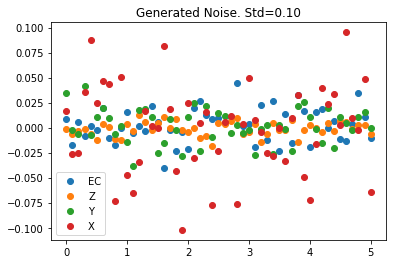

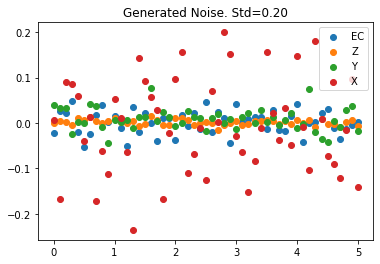

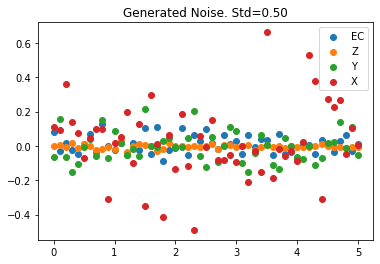

In [20]:
for std in STDS:
    generateNoise(std)

# Question 2: Experiment Implementation

# Question 3: Experiment Execution and Analysis